In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import h5py
import matplotlib.pyplot as plt
from real_data_manager import RealData
from ImageFactory import ImageFactory
from MagCounts import Mag2Counts, Count2Mag
from psf_sampler import PSFSampler

## Plots to do
- sky_brightness, seeing, airmass, zero_point vs MJD
- Pixel distributions for different constant stars through time (pay atention to psf)
- Lightcurve in count variance for constant stars
    - computed with different zero points
    - computed filtering bad zero points
- Estimated sky from image and variance, and estimated sky
- Lightcurve in magnitude and count variance for RRLyrae, Eclipsing Binaries and NonVariables for similar magnitude distribution

In [2]:
#sim_data_path = "/home/rodrigo/supernovae_detection/simulated_data/image_sequences/small_may30_erf_distr50.hdf5"
sim_data_path = "/home/rcarrasco/simulated_data/image_sequences/complete_june8_erf_distr2500.hdf5"
sim_data = h5py.File(sim_data_path, "r")
fields = list(sim_data.keys())

### Observation conditions

In [3]:
print(list(sim_data[fields[0]]["obs_cond"].keys()))
keys_to_plot = ["flux_conversion","zero_point", "seeing", "airmass", "limmag5", "sky_brightness"]

['airmass', 'epoch', 'exp_time', 'filter', 'flux_conversion', 'good_quality_points', 'limmag3', 'limmag5', 'obs_day', 'seeing', 'sky_brightness', 'zero_point']


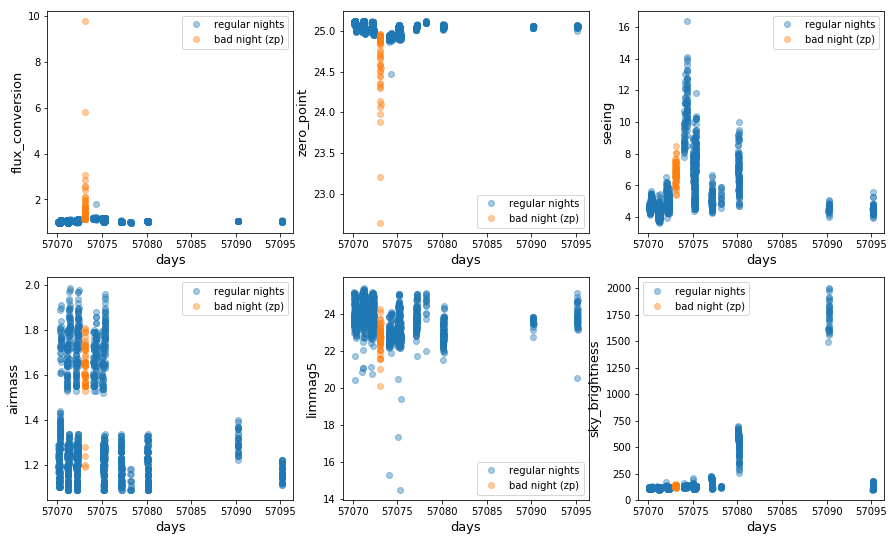

In [4]:
f, ax = plt.subplots(2, 3, figsize=(15,9))
ax = np.reshape(ax, newshape=(6,))
for i, key in enumerate(keys_to_plot):
    all_params = []
    all_days = []
    for field in fields:
        param = sim_data[field]["obs_cond"][key]["g"][:]
        days = sim_data[field]["obs_cond"]["obs_day"]["g"][:]
        all_params.append(param)
        all_days.append(days)
    all_params = np.concatenate(all_params)
    all_days = np.concatenate(all_days)
    bad_night_limits = [57072.7, 57073.5]
    regular_nights_index = np.logical_or(all_days>bad_night_limits[1], all_days<bad_night_limits[0])
    regular_nights_days = all_days[regular_nights_index]
    regular_nights_params = all_params[regular_nights_index]
    bad_night_days = all_days[np.logical_not(regular_nights_index)]
    bad_night_params = all_params[np.logical_not(regular_nights_index)]
    ax[i].plot(regular_nights_days, regular_nights_params, "o", alpha=0.4, label="regular nights")
    ax[i].plot(bad_night_days, bad_night_params, "o", alpha=0.4, label="bad night (zp)")
    ax[i].legend()
    ax[i].set_xlabel("days", fontsize=13)
    ax[i].set_ylabel(key, fontsize=13)
plt.show()

### Image comparison (constants)

In [5]:
real_data = RealData(sim_data_path=sim_data_path,
                    sequence_length=20,
                    tensor_length=3,
                    real_data_path="../real_obs/real_stamps/")
rr_lyrae_data = real_data.return_real_data("RRLyrae", label=1, filter_by_cond=True)
nonvariable_data = real_data.return_real_data("real_constants", label=3, filter_by_cond=True)
EB_data = real_data.return_real_data("EB", label=2, filter_by_cond=True)

Real data keys: 
EB, RRLyrae, real_constants, sim_constants


In [6]:
real_stamp_list = nonvariable_data["filtered_stamps"]
real_lightcurve_list = nonvariable_data["lightcurve_mag"]
real_counts_list = nonvariable_data["original_lc_counts"]
real_obs_fields = nonvariable_data["field"]
real_days_list = nonvariable_data["days"]
real_obs_index = nonvariable_data["match_index"]
real_obs_cam = nonvariable_data["camera"]

In [7]:
#galaxy_path = "/home/rodrigo/supernovae_detection/galaxies/gal_mags_dev_exp_z_all_Filter_rodrigocd.csv"
galaxy_path = "/home/rcarrasco/simulated_data/galaxies/gal_mags_dev_exp_z_all_Filter_rodrigocd.csv"
obs_cond_path = "../real_obs/pickles/camera_and_obs_cond.pkl"
camera_and_obs_cond = np.load(obs_cond_path)
camera_params = camera_and_obs_cond["camera_params"]
available_cameras = camera_params.keys()
image_factory = ImageFactory(nx=21,
                             ny=21,
                             astrometric_error=0.3, #not used
                             galaxies_distr_path=galaxy_path,
                             bands=["g",],
                             sky_clipping=2000,
                             ccd_parameters=camera_params["CCD25"],
                             real_psfs=True,
                             obs_cond_path=obs_cond_path,
                             augmented_psfs=False)

- Using PSF sampler
Doing gaussian fit to psf to compute SEEING
- Galaxy images


In [8]:
available_cameras

dict_keys(['CCD1', 'CCD5', 'CCD6', 'CCD7', 'CCD9', 'CCD11', 'CCD12', 'CCD13', 'CCD14', 'CCD15', 'CCD16', 'CCD18', 'CCD19', 'CCD20', 'CCD21', 'CCD22', 'CCD23', 'CCD25', 'CCD26', 'CCD27', 'CCD28', 'CCD29', 'CCD30', 'CCD33', 'CCD34', 'CCD35', 'CCD36', 'CCD37', 'CCD38', 'CCD39', 'CCD40', 'CCD41', 'CCD43', 'CCD45', 'CCD47', 'CCD48', 'CCD50', 'CCD51', 'CCD52', 'CCD53', 'CCD54', 'CCD56', 'CCD57', 'CCD58', 'CCD59', 'CCD60', 'CCD62'])

In [10]:
def complete_image(stamp_array, real=True):
    if not real:
        stamp_array = np.moveaxis(stamp_array, 2, 0)
    image_dim = (2, 11) # (2, 11) for paper
    images_to_plot = np.zeros(shape=(21*image_dim[0], 21*image_dim[1]))
    n_images = 0
    break_cond = False
    for row in range(image_dim[0]):
        if break_cond:
            break
        for column in range(image_dim[1]):
            if n_images >= stamp_array.shape[0]:
                #print("break")
                break_cond = True
                break
            row_limits = [21*row, 21*(row+1)]
            column_limits = [21*column, 21*(column+1)]
            stamp = stamp_array[n_images, :, :]
            images_to_plot[row_limits[0]:row_limits[1], column_limits[0]:column_limits[1]] = stamp
            n_images += 1
    return images_to_plot

def search_index(mag, lightcurves, cameras, available_cameras):
    closest_diff = 1000
    closest_index = 0
    closest_mag = 0
    for i, lc in enumerate(lightcurves):
        diff = np.abs(mag - lc[0])
        if diff < closest_diff and cameras[i] in available_cameras:
            closest_diff = diff
            closest_index = i
            closest_mag = lc[0]
    return closest_mag, closest_index

def build_histograms(real_object, sim_list, matched_index):
    real_pixel_histogram = []
    sim_pixel_histogram = []
    bins_list = []
    for i in range(sim_list[0].shape[-1]):
        pixel_array = np.reshape(real_object[0, ...], newshape=(21*21,))
        min_bin = np.amin(pixel_array) - 50
        max_bin = np.amax(pixel_array) + 50
        bins = np.linspace(start=min_bin, stop=max_bin, num=20)
        h, _ = np.histogram(pixel_array, bins=bins, density=True)
        real_pixel_histogram.append(h)
        total_sim_array = []
        for sim in sim_list:
            #all_stamps = sim[..., matched_index]
            stamp = sim[..., i]
            total_sim_array.append(np.reshape(stamp, newshape=(21*21,)))
        total_sim_array = np.concatenate(total_sim_array)
        h, _ = np.histogram(total_sim_array, bins=bins, density=True)
        sim_pixel_histogram.append(h)
        bins_list.append(bins)
    histogram_data = {"real": real_pixel_histogram, 
                      "sim": sim_pixel_histogram, 
                      "bins": bins}
    return histogram_data

def plot_comparison(complete_real, complete_sim, histogram_data, name="comp", magnitude=20):
    fontsize = 17
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    f, ax = plt.subplots(2, 1, figsize=(15,8))
    im1 = ax[0].imshow(complete_real)
    #plt.colorbar(im, ax=ax[0])
    ax[0].set_axis_off()
    ax[0].set_title("Real observation image sequence, magnitude = "+'{0:.2f}'.format(magnitude),
                   fontsize = fontsize)
    #ax[0].set_aspect('auto')
    
    divider1 = make_axes_locatable(ax[0])
    cax1 = divider1.append_axes("right", size="5%", pad=0.05)
    f.colorbar(im1, cax=cax1)
    
    complete_sim += np.random.normal(size=complete_sim.shape, scale=15)
    im2 = ax[1].imshow(complete_sim)
    #plt.colorbar(im, ax=ax[1])
    ax[1].set_axis_off()
    ax[1].set_title("Simulated image sequence",
                   fontsize=fontsize)
    divider2 = make_axes_locatable(ax[1])
    cax2 = divider2.append_axes("right", size="5%", pad=0.05)
    f.colorbar(im2, cax=cax2)
    #ax[1].set_aspect('auto')
    plt.subplots_adjust(hspace = -0.3)
    plt.savefig("plots/"+name+".pdf", bbox_inches="tight")
    plt.show()
    
    real_histogram = histogram_data["real"]
    sim_histogram = histogram_data["sim"]
    bins = histogram_data["bins"]
    
    #f, ax = plt.subplots(3, 6, figsize=(16,10))
    #ax = np.reshape(ax, newshape=(3*6,))
    #for epoch, r_h in enumerate(real_histogram[:18]):
    #    ax[epoch].plot(bins[1:], r_h, label="real")
    #    ax[epoch].plot(bins[1:], sim_histogram[epoch], label="sim")
    #    ax[epoch].set_title("epoch "+str(epoch))
    #    ax[epoch].legend()
    #plt.savefig("plots/"+name+".pdf")
    #plt.show()
    plt.close("all")
    return

[57070.13 57070.22 57070.28 57070.33 57071.06 57071.12 57071.19 57071.26
 57071.33 57072.06 57072.12 57072.19 57072.26 57072.33 57073.05 57074.05
 57074.32 57075.04 57075.12 57075.18 57075.25 57075.32 57077.1  57077.16
 57080.09 57080.16]
[57070.13 57070.21 57070.28 57070.33 57071.06 57071.13 57071.19 57071.26
 57071.33 57072.05 57072.12 57072.19 57072.26 57072.33 57075.11 57075.18
 57075.25 57077.1  57077.16 57080.09 57080.16]


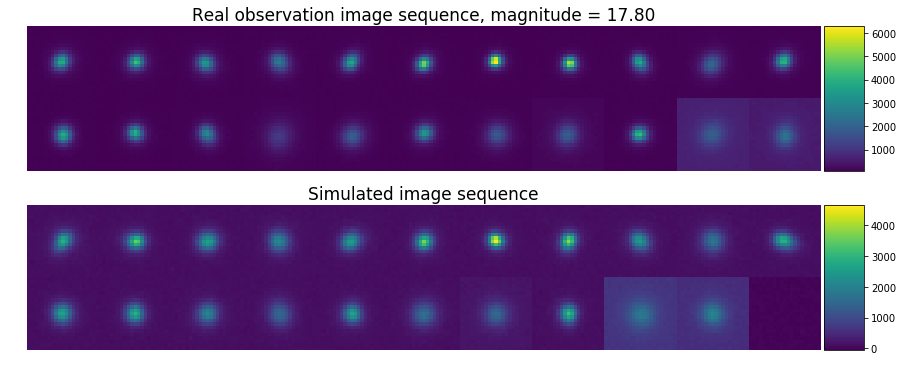

[57070.11 57070.2  57070.26 57071.04 57071.11 57071.18 57071.24 57071.31
 57072.04 57072.1  57072.17 57072.24 57072.31 57073.04 57073.1  57074.03
 57074.3  57075.03 57075.1  57075.16 57075.24 57075.3  57077.08 57077.14
 57080.08 57080.14]
[57070.11 57070.2  57070.26 57071.04 57071.11 57071.18 57071.24 57071.31
 57072.04 57072.1  57072.17 57072.24 57072.31 57073.03 57073.1  57075.03
 57075.1  57075.16 57075.23 57077.08 57077.14 57080.07 57080.14]


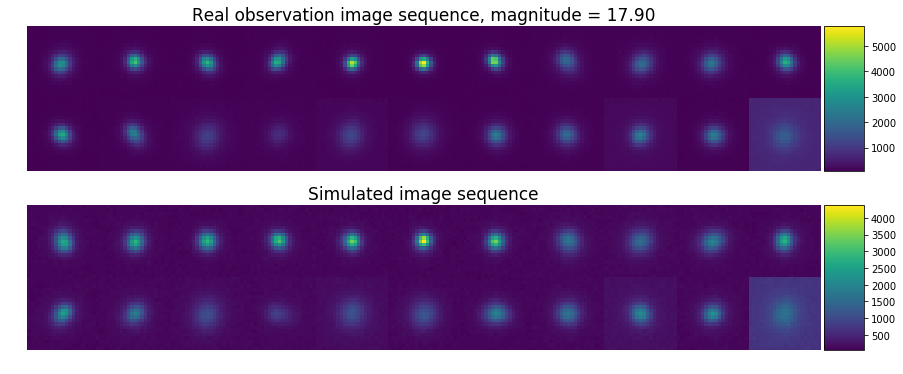

[57070.11 57070.2  57070.26 57071.04 57071.11 57071.18 57071.24 57071.31
 57072.04 57072.1  57072.17 57072.24 57072.31 57073.04 57073.1  57074.03
 57074.3  57075.03 57075.1  57075.16 57075.24 57075.3  57077.08 57077.14
 57080.08 57080.14]
[57070.11 57070.2  57070.26 57071.04 57071.11 57071.18 57071.24 57071.31
 57072.04 57072.1  57072.17 57072.24 57072.31 57073.03 57073.1  57075.03
 57075.1  57075.16 57075.23 57077.08 57077.14 57080.07 57080.14]


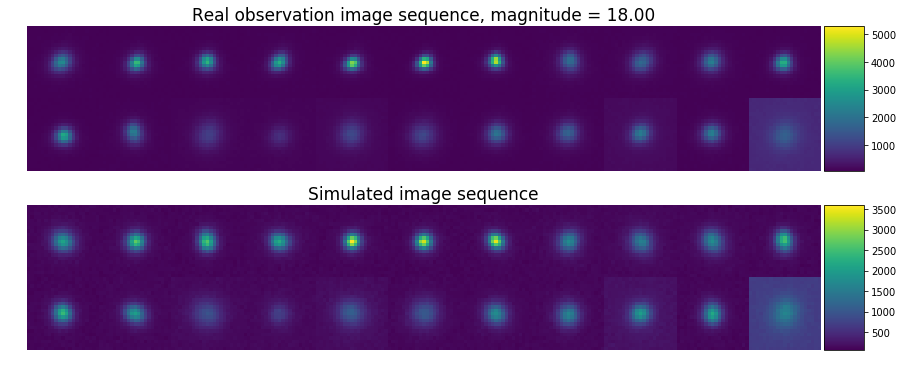

[57070.12 57070.2  57070.28 57071.05 57071.12 57071.18 57071.26 57071.32
 57072.04 57072.12 57072.18 57072.25 57072.32 57073.04 57074.04 57074.31
 57075.04 57075.1  57075.18 57075.24 57075.31 57077.09 57077.15 57080.08
 57080.15]
[57070.12 57070.21 57070.27 57071.05 57071.12 57071.18 57071.25 57071.32
 57072.05 57072.11 57072.18 57072.25 57072.32 57073.04 57075.04 57075.11
 57075.17 57075.24 57077.09 57077.15]


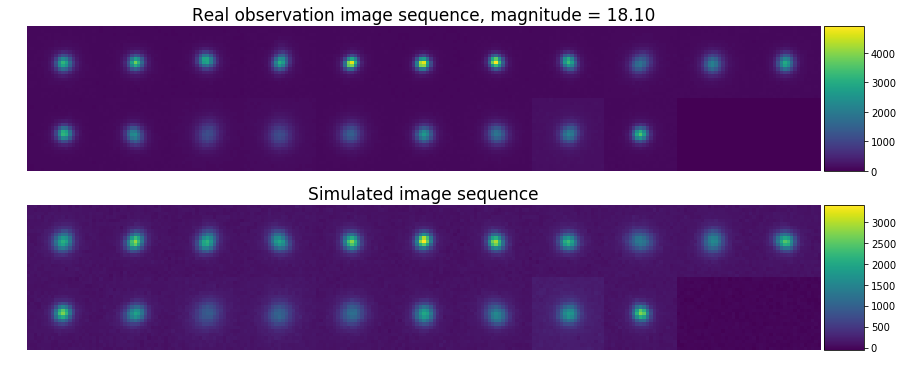

[57070.12 57070.2  57070.28 57071.04 57071.12 57071.18 57071.25 57071.32
 57072.04 57072.12 57072.18 57072.25 57072.32 57073.04 57074.04 57074.3
 57075.04 57075.1  57075.17 57075.24 57075.31 57077.09 57077.15 57080.08
 57080.15]
[57070.12 57070.2  57070.27 57071.05 57071.12 57071.18 57071.25 57071.32
 57072.04 57072.11 57072.18 57072.25 57072.32 57073.04 57075.04 57075.1
 57075.17 57075.24 57075.31 57077.09 57077.15 57080.15]


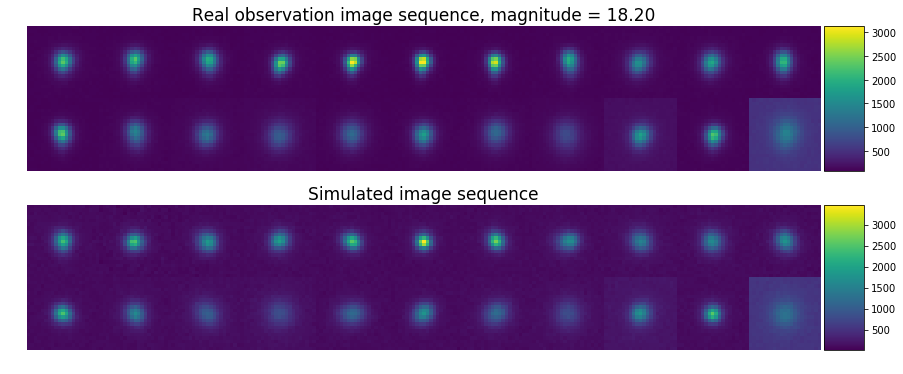

[57070.13 57070.21 57070.28 57071.06 57071.12 57071.19 57071.26 57071.33
 57072.06 57072.12 57072.19 57072.26 57072.33 57073.05 57074.04 57074.32
 57075.04 57075.12 57075.18 57075.25 57075.32 57077.1  57077.16 57080.09
 57080.16]
[57070.13 57070.21 57070.28 57071.06 57071.12 57071.19 57071.26 57071.33
 57072.05 57072.12 57072.19 57072.26 57072.33 57075.11 57075.18 57075.25
 57077.1  57077.16 57080.16]


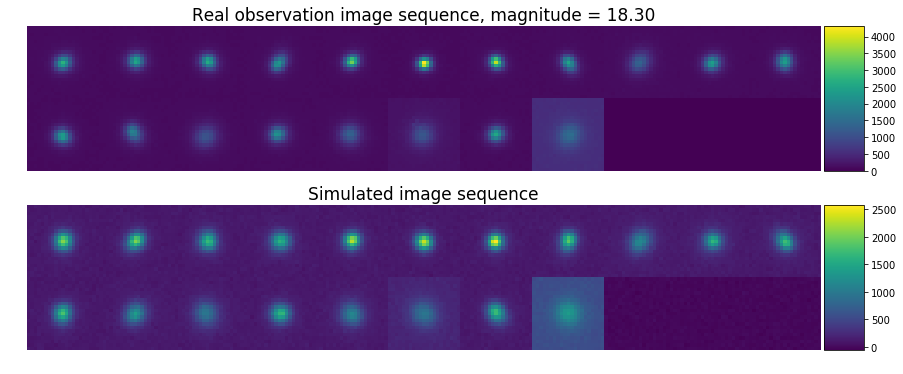

[57070.12 57070.2  57070.28 57071.04 57071.12 57071.18 57071.25 57071.32
 57072.04 57072.12 57072.18 57072.25 57072.32 57073.04 57074.04 57074.3
 57075.04 57075.1  57075.17 57075.24 57075.31 57077.09 57077.15 57080.08
 57080.15]
[57070.12 57070.2  57070.27 57071.05 57071.12 57071.18 57071.25 57071.32
 57072.04 57072.11 57072.18 57072.25 57072.32 57073.04 57075.04 57075.1
 57075.17 57075.24 57075.31 57077.09 57077.15 57080.15]


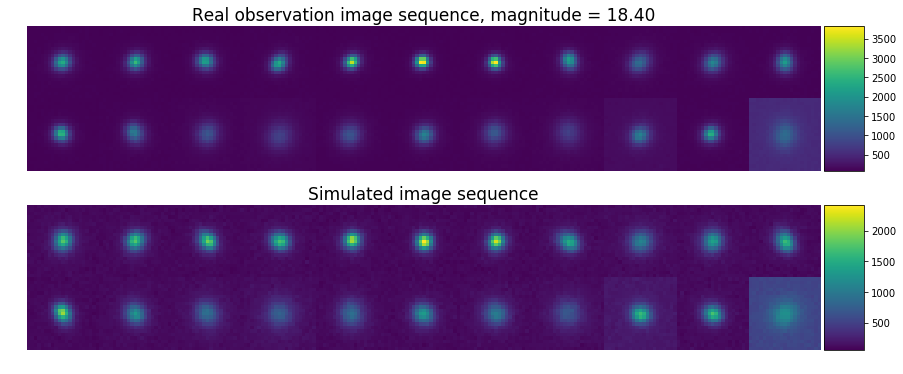

[57070.11 57070.2  57070.26 57071.04 57071.11 57071.18 57071.24 57071.31
 57072.04 57072.1  57072.17 57072.24 57072.31 57073.04 57073.1  57074.03
 57074.3  57075.03 57075.1  57075.16 57075.24 57075.3  57077.08 57077.14
 57080.08 57080.14]
[57070.11 57070.2  57070.26 57071.04 57071.11 57071.18 57071.24 57071.31
 57072.04 57072.1  57072.17 57072.24 57072.31 57073.03 57073.1  57075.03
 57075.1  57075.16 57075.23 57077.08 57077.14 57080.07 57080.14]


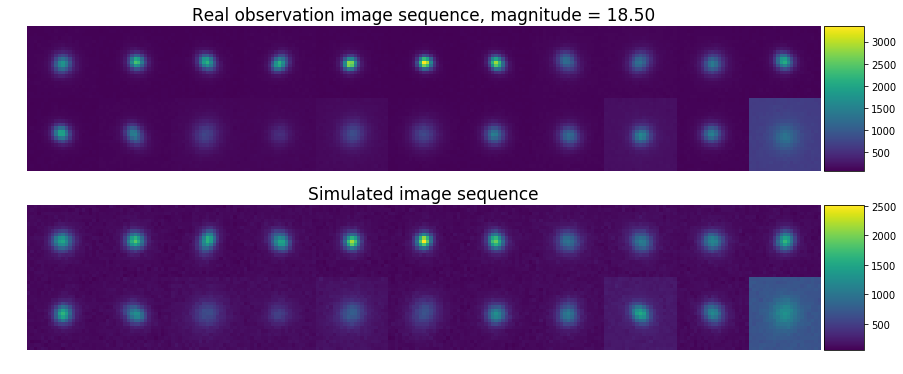

[57070.13 57070.21 57070.28 57071.06 57071.12 57071.19 57071.26 57071.33
 57072.06 57072.12 57072.19 57072.26 57072.33 57073.05 57074.04 57074.32
 57075.04 57075.12 57075.18 57075.25 57075.32 57077.1  57077.16 57080.09
 57080.16]
[57070.13 57070.21 57070.28 57071.06 57071.12 57071.19 57071.26 57071.33
 57072.05 57072.12 57072.19 57072.26 57072.33 57075.11 57075.18 57075.25
 57077.1  57077.16 57080.16]


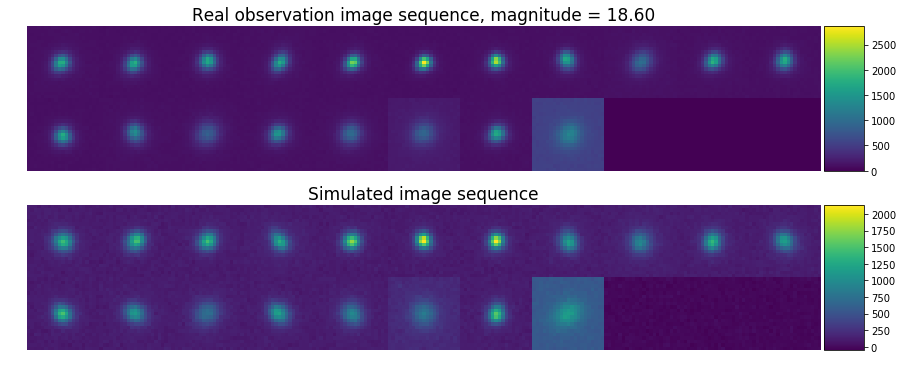

[57070.12 57070.2  57070.28 57071.04 57071.12 57071.18 57071.25 57071.32
 57072.04 57072.11 57072.18 57072.25 57072.32 57073.04 57074.04 57074.3
 57075.04 57075.1  57075.17 57075.24 57075.31 57077.09 57077.15 57080.08
 57080.15]
[57070.12 57070.2  57070.27 57071.05 57071.11 57071.18 57071.25 57071.32
 57072.04 57072.11 57072.18 57072.25 57072.32 57073.04 57075.04 57075.1
 57075.17 57075.24 57077.09 57077.15 57080.15]


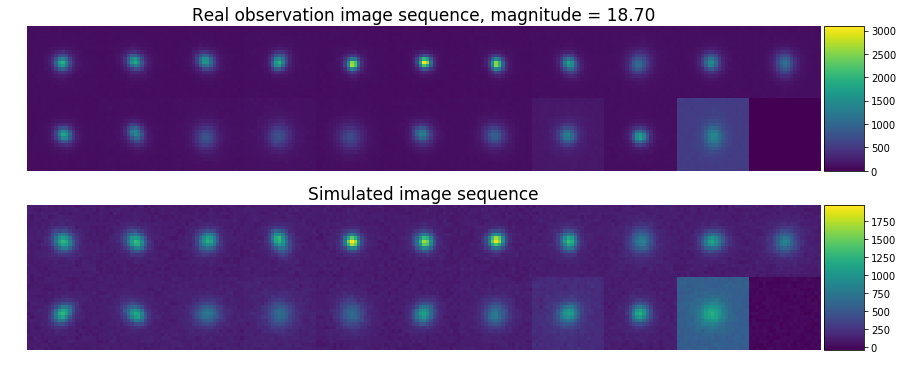

[57070.12 57070.2  57070.28 57071.04 57071.12 57071.18 57071.25 57071.32
 57072.04 57072.12 57072.18 57072.25 57072.32 57073.04 57074.04 57074.3
 57075.04 57075.1  57075.17 57075.24 57075.31 57077.09 57077.15 57080.08
 57080.15]
[57070.12 57070.2  57070.27 57071.05 57071.12 57071.18 57071.25 57071.32
 57072.04 57072.11 57072.18 57072.25 57072.32 57073.04 57075.04 57075.1
 57075.17 57075.24 57075.31 57077.09 57077.15 57080.15]


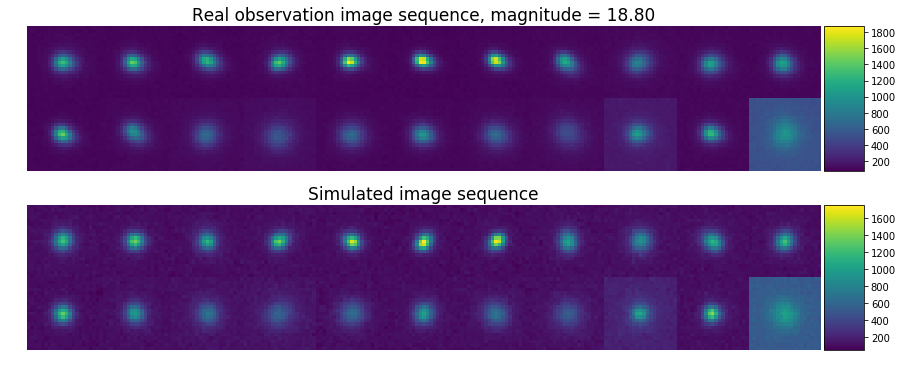

[57070.12 57070.2  57070.28 57071.05 57071.12 57071.18 57071.26 57071.32
 57072.04 57072.12 57072.18 57072.25 57072.32 57073.04 57074.04 57074.31
 57075.04 57075.1  57075.18 57075.24 57075.31 57077.09 57077.15 57080.08
 57080.15]
[57070.12 57070.21 57070.27 57071.05 57071.12 57071.18 57071.25 57071.32
 57072.05 57072.11 57072.18 57072.25 57072.32 57073.04 57075.04 57075.11
 57075.17 57075.24 57077.09 57077.15]


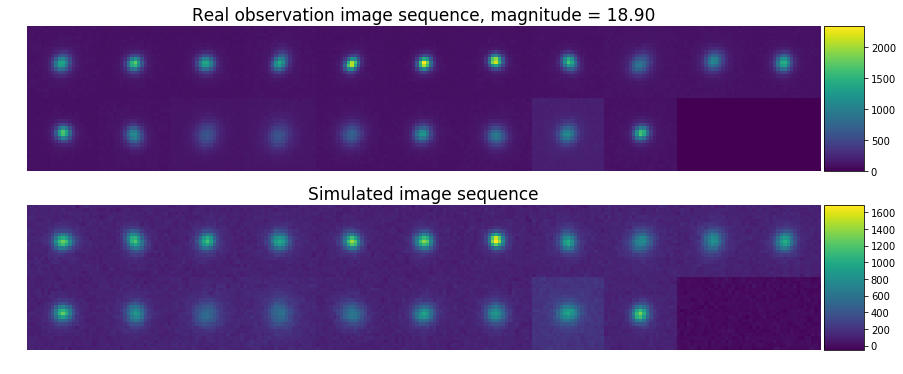

[57070.13 57070.22 57070.28 57070.33 57071.06 57071.12 57071.19 57071.26
 57071.33 57072.06 57072.12 57072.19 57072.26 57072.33 57073.05 57074.05
 57074.32 57075.04 57075.12 57075.18 57075.25 57075.32 57077.1  57077.16
 57080.09 57080.16]
[57070.13 57070.21 57070.28 57070.33 57071.06 57071.13 57071.19 57071.26
 57071.33 57072.05 57072.12 57072.19 57072.26 57072.33 57075.11 57075.18
 57075.25 57077.1  57077.16 57080.09 57080.16]


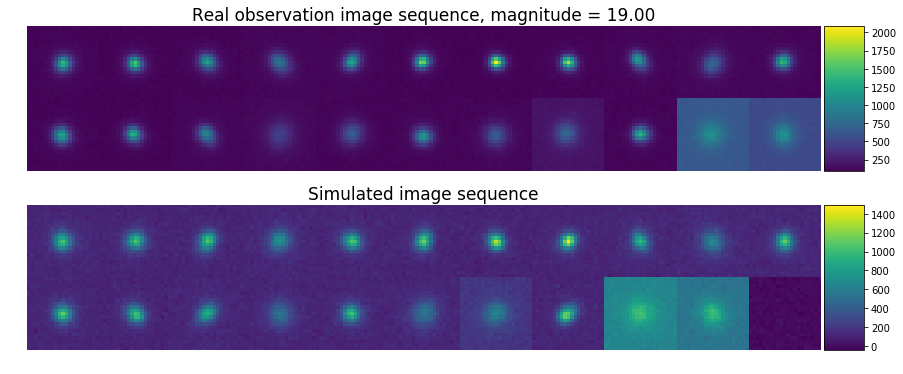

[57070.13 57070.22 57070.28 57070.33 57071.06 57071.12 57071.19 57071.26
 57071.33 57072.06 57072.12 57072.19 57072.26 57072.33 57073.05 57074.05
 57074.32 57075.04 57075.12 57075.18 57075.25 57075.32 57077.1  57077.16
 57080.09 57080.16]
[57070.13 57070.21 57070.28 57070.33 57071.06 57071.13 57071.19 57071.26
 57071.33 57072.05 57072.12 57072.19 57072.26 57072.33 57075.11 57075.18
 57075.25 57077.1  57077.16 57080.09 57080.16]


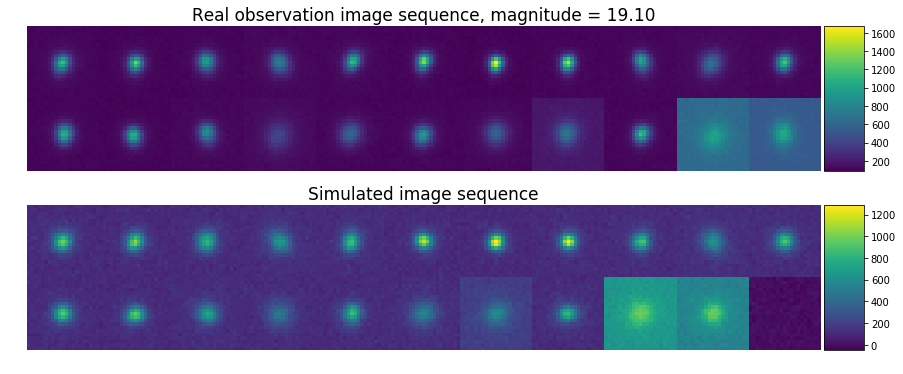

[57070.12 57070.2  57070.28 57071.04 57071.12 57071.18 57071.25 57071.32
 57072.04 57072.11 57072.18 57072.25 57072.32 57073.04 57074.04 57074.3
 57075.04 57075.1  57075.17 57075.24 57075.31 57077.09 57077.15 57080.08
 57080.15]
[57070.12 57070.2  57070.27 57071.05 57071.11 57071.18 57071.25 57071.32
 57072.04 57072.11 57072.18 57072.25 57072.32 57073.04 57075.04 57075.1
 57075.17 57075.24 57077.09 57077.15 57080.15]


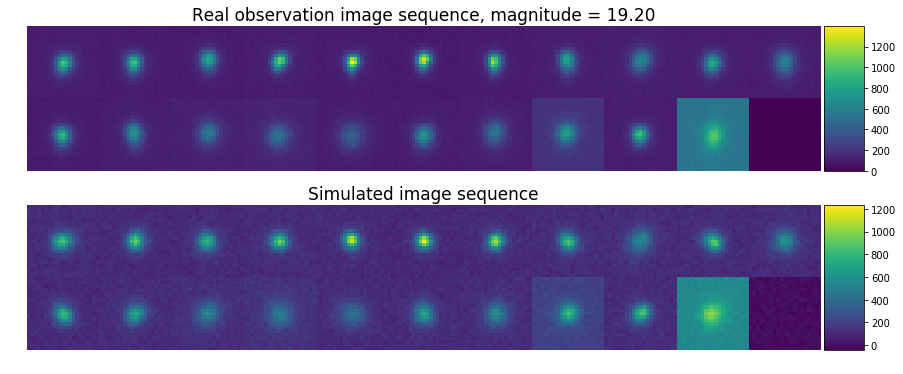

[57070.12 57070.2  57070.28 57071.04 57071.12 57071.18 57071.25 57071.32
 57072.04 57072.12 57072.18 57072.25 57072.32 57073.04 57074.04 57074.3
 57075.04 57075.1  57075.17 57075.24 57075.31 57077.09 57077.15 57080.08
 57080.15]
[57070.12 57070.2  57070.27 57071.05 57071.12 57071.18 57071.25 57071.32
 57072.04 57072.11 57072.18 57072.25 57072.32 57073.04 57075.04 57075.1
 57075.17 57075.24 57075.31 57077.09 57077.15 57080.15]


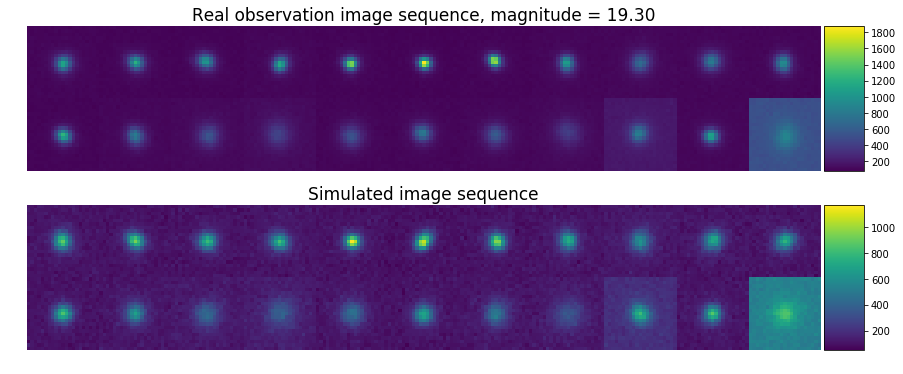

[57070.13 57070.21 57070.28 57071.06 57071.12 57071.19 57071.26 57071.33
 57072.06 57072.12 57072.19 57072.26 57072.33 57073.05 57074.04 57074.32
 57075.04 57075.12 57075.18 57075.25 57075.32 57077.1  57077.16 57080.09
 57080.16]
[57070.13 57070.21 57070.28 57071.06 57071.12 57071.19 57071.26 57071.33
 57072.05 57072.12 57072.19 57072.26 57072.33 57075.11 57075.18 57075.25
 57077.1  57077.16 57080.16]


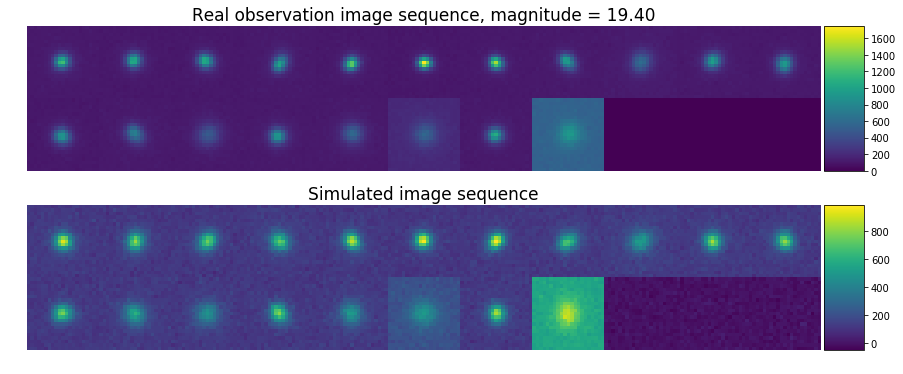

[57070.15 57070.24 57070.3  57070.35 57071.08 57071.15 57071.22 57071.28
 57071.36 57072.08 57072.14 57072.22 57072.28 57072.35 57073.08 57074.07
 57074.34 57075.06 57075.14 57075.2  57075.28 57075.34 57077.12 57077.18
 57078.19 57080.12 57080.18 57090.24 57095.18]
[57070.15 57070.24 57070.3  57070.35 57071.08 57071.15 57071.21 57071.28
 57071.35 57072.08 57072.14 57072.21 57072.28 57072.35 57073.07 57075.14
 57075.2  57077.12 57077.18 57078.19 57080.11 57080.18 57090.24 57095.18]


/home/rcarrasco/miniconda3/envs/my_python/lib/python3.6/site-packages/numpy/lib/function_base.py:838: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


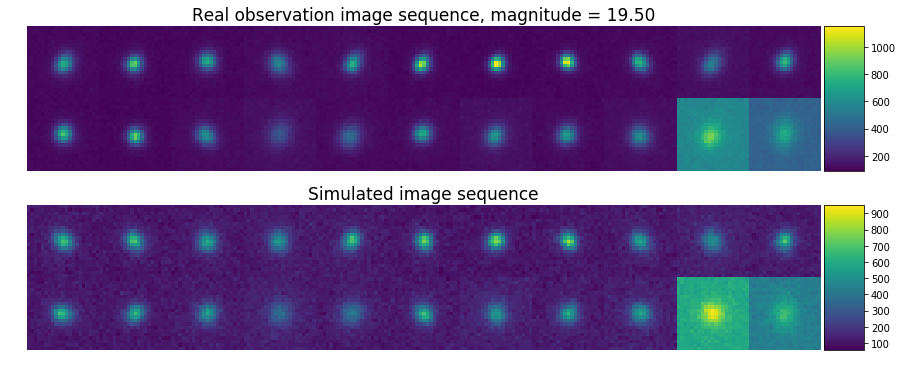

[57070.12 57070.2  57070.28 57071.04 57071.12 57071.18 57071.25 57071.32
 57072.04 57072.12 57072.18 57072.25 57072.32 57073.04 57074.04 57074.3
 57075.04 57075.1  57075.17 57075.24 57075.31 57077.09 57077.15 57080.08
 57080.15]
[57070.12 57070.2  57070.27 57071.05 57071.12 57071.18 57071.25 57071.32
 57072.04 57072.11 57072.18 57072.25 57072.32 57073.04 57075.04 57075.1
 57075.17 57075.24 57075.31 57077.09 57077.15 57080.15]


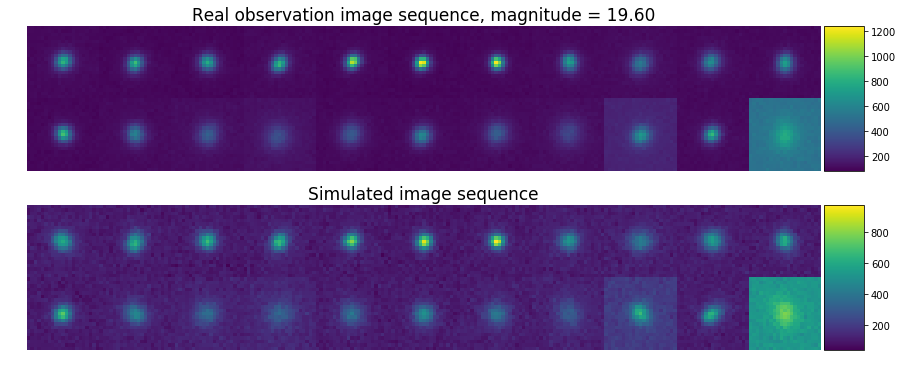

In [11]:
mags_to_plot = np.arange(start=17.8, stop=19.7, step=0.1)
# mags_to_plot = [17.8, 18.0, 18.2, 18.5, 18.8, 19.0, 19.5]
n_simulated_per_mag = 10

for k, m in enumerate(mags_to_plot):
    m_found, index = search_index(m, real_lightcurve_list, real_obs_cam, available_cameras)
    real_object = real_stamp_list[index]
    sim_stamps = []
    field = real_obs_fields[index]
    camera = real_obs_cam[index]
    matched_index = real_obs_index[index]
    #print(len(counts["g"][0,...]), len(matched_index))
    
    seeing = sim_data[field]["obs_cond"]["seeing"]
    sky = sim_data[field]["obs_cond"]["sky_brightness"]
    exp_time = sim_data[field]["obs_cond"]["exp_time"]
    zero_point = sim_data[field]["obs_cond"]["zero_point"]
    good_quality_points = sim_data[field]["obs_cond"]["good_quality_points"]["g"][:]
    sim_days = sim_data[field]["obs_cond"]["obs_day"]["g"][:]
    sim_data_length = len(good_quality_points)
    real_image = complete_image(real_object[:sim_data_length])
    #print(len(sky["g"][:]))
    with_galaxy = False
    airmass = None
    counts = real_counts_list[index][:len(sky["g"][:])]
    counts = {"g": np.reshape(counts[:], (1, len(counts)))}
    print(np.round(real_days_list[index], decimals=2))
    print(np.round(sim_days[good_quality_points], decimals=2))
    
    
    for i in range(n_simulated_per_mag):
        sim_images = image_factory.createLightCurveImages(counts=counts,
                                                          seeing=seeing,
                                                          airmass=airmass,
                                                          sky_counts=sky,
                                                          exp_time=exp_time,
                                                          zero_point=zero_point,
                                                          with_galaxy=with_galaxy)
        sim_stamp = sim_images[0]["g"]
        sim_stamp = sim_stamp[..., good_quality_points]
        if i == 0:
            stamp_to_plot = sim_stamp
            sim_image = complete_image(stamp_to_plot, real=False)
        sim_stamps.append(sim_stamp)
        
    histogram_data = build_histograms(real_object, sim_stamps, matched_index)
    plot_comparison(real_image, sim_image, histogram_data, "comp"+str(k), magnitude=m)

In [21]:
total_seeing = []
for f in fields:
    seeing = sim_data[f]["obs_cond"]["seeing"]["g"][:]
    total_seeing.append(seeing)
total_seeing = np.concatenate(total_seeing)
print(np.amin(total_seeing), np.amax(total_seeing))

3.635 16.4


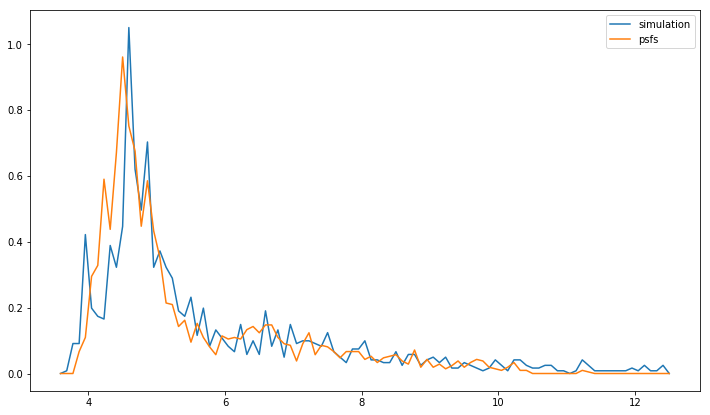

3.7956006935265325 11.24176022550953


In [25]:
sampler = image_factory.psf_sampler
seeing_to_plot = np.arange(start=4, stop=10, step=0.3)
bins = np.linspace(3.5, 12.5, num=100)
h_sim, _ = np.histogram(total_seeing, bins=bins, density=True)
h_psf, _ = np.histogram(sampler.psf_seeing, bins=bins, density=True)
plt.figure(figsize=(12,7))
plt.plot(bins[1:], h_sim, label="simulation")
plt.plot(bins[1:], h_psf, label="psfs")
plt.legend()
plt.show()
print(np.amin(sampler.psf_seeing), np.amax(sampler.psf_seeing))

4.0000198062577725 4.0


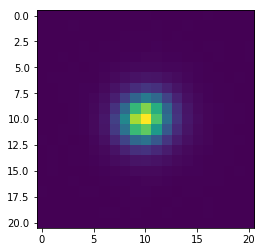

4.300661460262536 4.3


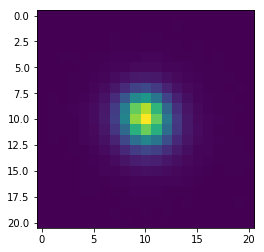

4.600565170938249 4.6


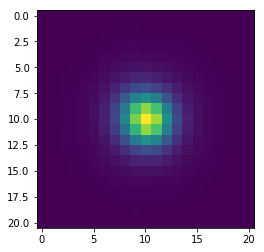

4.899179712635003 4.8999999999999995


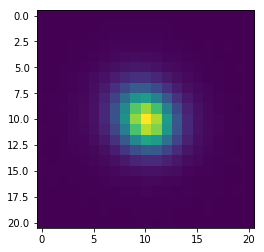

5.199791073557605 5.199999999999999


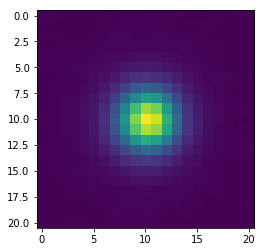

5.50465504915437 5.499999999999999


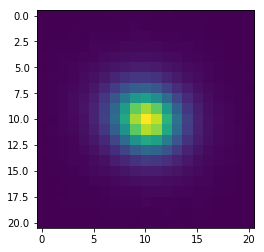

5.803131878810679 5.799999999999999


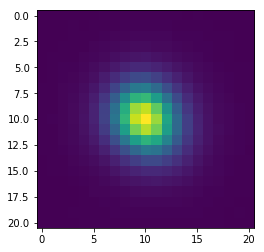

6.098232810452592 6.099999999999999


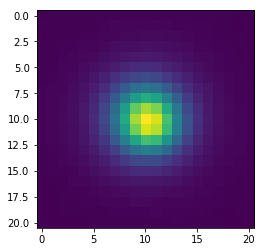

6.397127152489878 6.399999999999999


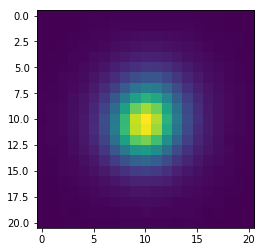

6.700901258324856 6.699999999999998


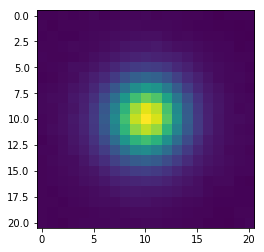

6.995020158204381 6.999999999999998


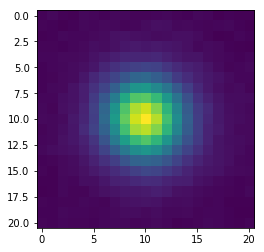

7.302824905544495 7.299999999999998


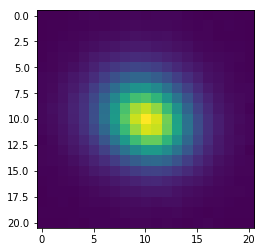

7.6055158333799575 7.599999999999998


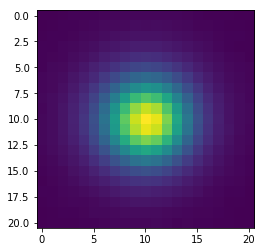

7.8997355136937895 7.899999999999998


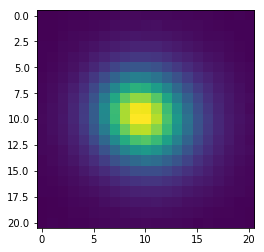

8.202459319880012 8.199999999999998


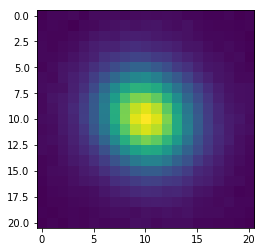

8.496275070089265 8.499999999999996


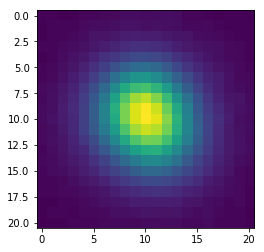

8.819654990440974 8.799999999999997


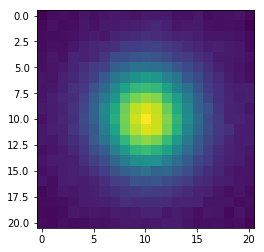

9.091992771772777 9.099999999999998


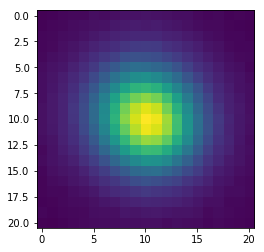

9.399722156121593 9.399999999999997


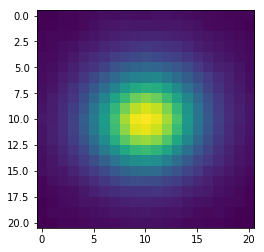

9.700833441924548 9.699999999999996


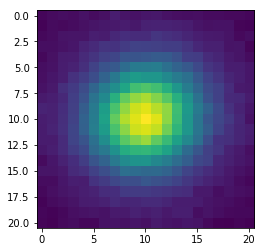

In [26]:
for s in seeing_to_plot:
    psf, real_s = sampler.sample_psf(s)
    print(real_s, s)
    plt.imshow(psf)
    plt.show()